#  **Projet Data Mining : Détection de Comptes Automatisés sur VK**


* ##  **Contexte**
VK (abréviation de "VKontakte") est un réseau social populaire en Russie, comparable à Facebook. 

Cependant, comme toute plateforme sociale, il est sujet à l’activité automatisée (bots) — souvent utilisés pour manipuler l’opinion publique, spammer ou collecter des données.

* ## **Objectif principal :** 
identifier ces comptes automatisés à partir de métadonnées utilisateurs.

* ## **Les methodes utilisées :** 
    * **Prétraitement** : SimpleImputer, StandardScaler, OneHotEncoder, ColumnTransformer, LabelEncoder
    * **Modèles :** DecisionTreeClassifier, RandomForestClassifier, SVM
    * **Évaluation :** classification_report, confusion_matrix, roc_auc_score 
    * **Interprétabilité des modèles :** shap, LimeTabularExplainer
    * **Validation croisée :** train_test_split , StratifiedKFold, cross_val_score

In [140]:
%%capture
!pip uninstall -y scikit-learn imbalanced-learn -q

!pip install scikit-learn==1.2.2 imbalanced-learn==0.9.1 -q

In [141]:
# Standard Library Imports
import warnings
import os
import gc
from math import ceil, sqrt

# Third-Party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import optuna
import shap
from plotly.subplots import make_subplots
import plotly.express as px

# Scipy Stats
from scipy.stats import (
    boxcox, 
    chi2_contingency, 
    skew, 
    kurtosis
)
from scipy.cluster.hierarchy import linkage, dendrogram

# Scikit-Learn Preprocessing
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    PowerTransformer,
    LabelEncoder,
    MinMaxScaler
)

# Scikit-Learn Model Selection
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV,
    ParameterGrid
)

# Scikit-Learn Feature Selection
from sklearn.feature_selection import (
    RFECV,
    RFE,
    SelectKBest,
    chi2,
    f_classif
)

# Scikit-Learn Decomposition
from sklearn.decomposition import PCA

# Scikit-Learn Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import (
    DecisionTreeClassifier,
    plot_tree
)
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier
)

# Scikit-Learn Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Scikit-Learn Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# Explainability Tools
from lime.lime_tabular import LimeTabularExplainer

# Configuration
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)
palette = {0: "royalblue", 1: "coral"}
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# **1. 📥 Chargement des données**

In [142]:
df=pd.read_csv("/kaggle/input/users-vs-bots-classification/bots_vs_users.csv")
df=df.dropna()

In [143]:
df.head()

,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,...,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness,city,has_occupation,occupation_type_university,occupation_type_work,has_personal_data
530,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,5.80,0.00,0.0,0.00,Unknown,Unknown,Unknown,Unknown,Unknown
568,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,30.80,0.00,0.0,0.67,Unknown,Unknown,Unknown,Unknown,Unknown
577,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,10.40,0.00,0.0,0.78,Unknown,Unknown,Unknown,Unknown,Unknown
578,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,12.80,0.00,0.0,0.76,Unknown,Unknown,Unknown,Unknown,Unknown
943,1.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,...,0.0,5.65,0.01,0.0,0.68,Velikie Luki,1.0,0.0,1.0,1.0


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1391 entries, 530 to 5873
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   has_domain                  1391 non-null   object 
 1   has_birth_date              1391 non-null   object 
 2   has_photo                   1391 non-null   object 
 3   can_post_on_wall            1391 non-null   object 
 4   can_send_message            1391 non-null   object 
 5   has_website                 1391 non-null   object 
 6   gender                      1391 non-null   object 
 7   has_short_name              1391 non-null   object 
 8   has_first_name              1391 non-null   object 
 9   has_last_name               1391 non-null   object 
 10  access_to_closed_profile    1391 non-null   object 
 11  is_profile_closed           1391 non-null   object 
 12  target                      1391 non-null   int64  
 13  has_nickname                1391 non

In [145]:
df.describe()

,target,posts_count,avg_likes,links_ratio,hashtags_ratio,avg_keywords,avg_text_length,attachments_ratio,avg_comments,reposts_ratio,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness
count,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000
mean,0.221423,18.629044,19.552487,0.156463,0.143918,7.730661,544.752035,0.895945,0.610812,0.433638,0.002667,623.834788,66.330065,0.000568,0.668009
std,0.415354,4.231994,41.954881,0.202730,0.187085,11.278711,746.728130,0.170084,2.461709,0.397830,0.033136,1617.635460,154.970296,0.009545,0.229815
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,0.400000,0.000000,0.000000,1.100000,86.600000,0.850000,0.000000,0.050000,0.000000,9.125000,1.980000,0.000000,0.580000
50%,0.000000,20.000000,7.600000,0.100000,0.050000,3.400000,267.800000,0.950000,0.000000,0.300000,0.000000,268.950000,30.950000,0.000000,0.710000
75%,0.000000,20.000000,26.075000,0.200000,0.200000,7.850000,616.850000,1.000000,0.200000,0.900000,0.000000,746.050000,89.480000,0.000000,0.830000
max,1.000000,20.000000,894.900000,1.000000,1.000000,61.600000,5841.250000,1.000000,64.050000,1.000000,0.950000,41415.700000,2866.590000,0.300000,1.000000


## 📊 Variables Quantitatives 

- `posts_count` : nombre total de publications.
- `avg_likes` : moyenne des likes par post.
- `links_ratio` : proportion de posts contenant des liens.
- `hashtags_ratio` : proportion de posts contenant des hashtags.
- `avg_keywords` : nombre moyen de mots-clés dans les publications.
- `avg_text_length` : longueur moyenne du texte des publications.
- `attachments_ratio` : proportion de posts avec pièces jointes.
- `avg_comments` : nombre moyen de commentaires par post.
- `reposts_ratio` : proportion de publications repartagées.
- `ads_ratio` : proportion de publications promotionnelles.
- `avg_views` : nombre moyen de vues par post.
- `posting_frequency_days` : fréquence moyenne de publication (en jours).
- `phone_numbers_ratio` : ratio de numéros de téléphone détectés.
- `avg_text_uniqueness` : taux d’unicité du texte (anti-duplication).

---

## 🔠 Variables Qualitatives 


- `has_domain` : l'utilisateur a un nom de domaine.
- `has_birth_date` : l'utilisateur a renseigné une date de naissance.
- `has_photo` : l'utilisateur a une photo de profil.
- `can_post_on_wall` : l'utilisateur peut publier sur son propre mur.
- `can_send_message` : l'utilisateur peut envoyer des messages.
- `has_website` : l'utilisateur a un site web.
- `gender` : genre de l'utilisateur.
- `has_short_name` : présence d’un nom court ou diminutif.
- `has_first_name` : l'utilisateur a un prénom.
- `has_last_name` : l'utilisateur a un nom de famille.
- `access_to_closed_profile` : accès à un profil privé.
- `is_profile_closed` : profil est privé ou public.
- `has_nickname` : présence d’un surnom.
- `has_maiden_name` : nom de jeune fille renseigné.
- `has_mobile` : numéro de téléphone présent.
- `all_posts_visible` : tous les posts sont visibles publiquement.
- `audio_available` : fichiers audio disponibles.
- `has_interests` : centres d’intérêt renseignés.
- `has_books` : livres favoris renseignés.
- `has_tv` : programmes TV renseignés.
- `has_quotes` : citations renseignées.
- `has_about` : section “à propos” complétée.
- `has_games` : joue à des jeux.
- `has_movies` : films préférés renseignés.
- `has_activities` : activités renseignées.
- `has_music` : goûts musicaux renseignés.
- `can_add_as_friend` : peut être ajouté comme ami.
- `can_invite_to_group` : peut inviter dans un groupe.
- `subscribers_count` : nombre d’abonnés.
- `is_blacklisted` : l'utilisateur est blacklisté.
- `has_career` : carrière professionnelle renseignée.
- `has_military_service` : service militaire renseigné.
- `has_hometown` : ville natale renseignée.
- `marital_status` : statut marital (célibataire, marié, etc.).
- `has_universities` : universités renseignées.
- `has_schools` : écoles renseignées.
- `has_relatives` : membres de la famille renseignés.
- `is_verified` : profil vérifié.
- `is_confirmed` : profil confirmé.
- `has_status` : statut personnel renseigné.
- `city` : ville actuelle.
- `has_occupation` : profession renseignée.
- `occupation_type_university` : travaille à l’université.
- `occupation_type_work` : travaille dans une entreprise.
- `has_personal_data` : infos personnelles complétées.

---

## 🎯 Variable Cible

- `target` : 0 pour robot, 1 pour humain.

---

# **2. 📊 Analyse exploratoire**

## **2.1  Prétraitement des variables quali**

### Class 1 (Human) VS Class 0 (Bot)

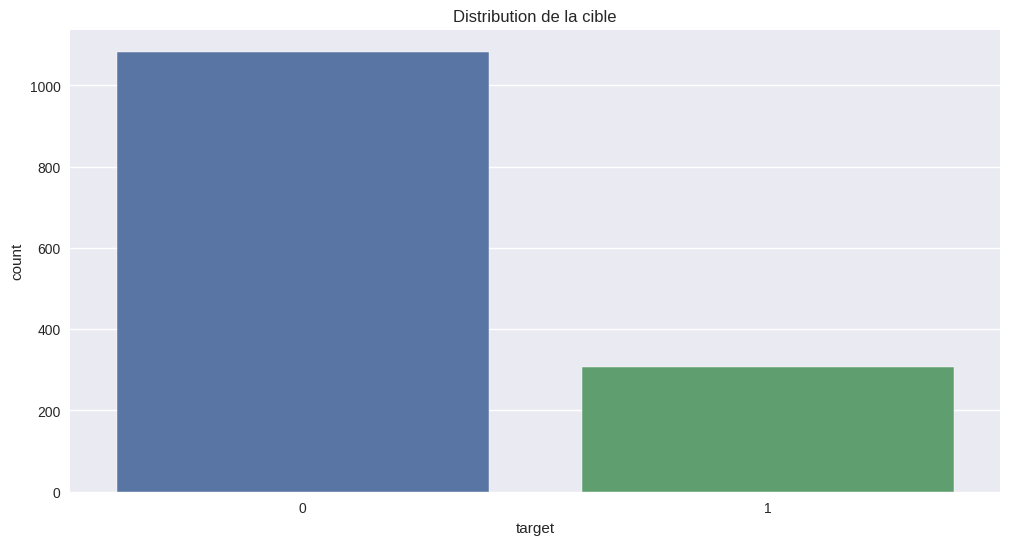

In [146]:
sns.countplot(x='target', data=df)
plt.title("Distribution de la cible")
plt.show()

## **2.2  Analyse exploratoire des variables quali**

In [147]:
variables_type_object=df.select_dtypes(include='object').columns.tolist()
variables_type_object

['has_domain',
 'has_birth_date',
 'has_photo',
 'can_post_on_wall',
 'can_send_message',
 'has_website',
 'gender',
 'has_short_name',
 'has_first_name',
 'has_last_name',
 'access_to_closed_profile',
 'is_profile_closed',
 'has_nickname',
 'has_maiden_name',
 'has_mobile',
 'all_posts_visible',
 'audio_available',
 'has_interests',
 'has_books',
 'has_tv',
 'has_quotes',
 'has_about',
 'has_games',
 'has_movies',
 'has_activities',
 'has_music',
 'can_add_as_friend',
 'can_invite_to_group',
 'subscribers_count',
 'is_blacklisted',
 'has_career',
 'has_military_service',
 'has_hometown',
 'marital_status',
 'has_universities',
 'has_schools',
 'has_relatives',
 'is_verified',
 'is_confirmed',
 'has_status',
 'city',
 'has_occupation',
 'occupation_type_university',
 'occupation_type_work',
 'has_personal_data']

In [148]:
len(variables_type_object)

45

### 🌍 Prétraitement de `city`

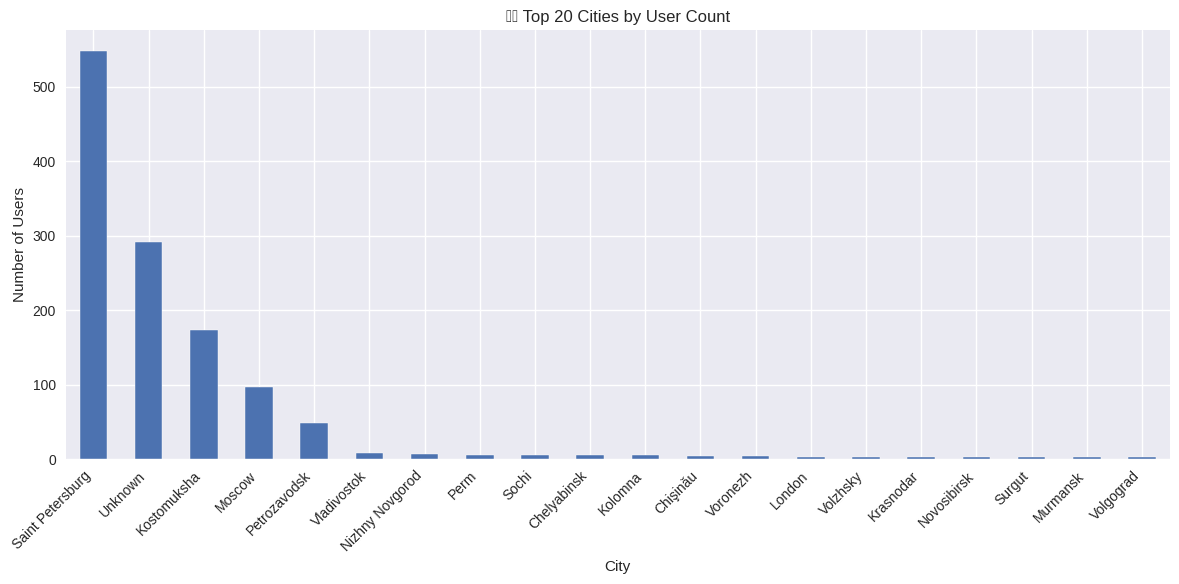

In [149]:
# Count city frequencies
city_counts = df['city'].value_counts().head(20)

# Plot
plt.figure(figsize=(12, 6))
city_counts.plot(kind='bar')
plt.title("🏙️ Top 20 Cities by User Count")
plt.xlabel("City")
plt.ylabel("Number of Users")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

On conserve uniquement les villes clés : `['Unknown', 'Saint Petersburg', 'Moscow']` et on regroupe toutes les autres sous `'Other'`.

➡️ Encodage : One-Hot sur la variable transformée, puis suppression de la colonne originale.

###  Prétraitement de `marital_status`

In [150]:
df['marital_status'].unique()

array(['0.0', '4.0', 'Unknown', '7.0', '1.0', '2.0', '6.0', '3.0'],
      dtype=object)

VK utilise un code numérique pour représenter le statut matrimonial des utilisateurs, donc il faudra les convertir en entiers

| Code  | Statut (FR)                    |
|-------|--------------------------------|
| 0     | Non spécifié                   |
| 1     | Célibataire                    |
| 2     | En couple                      |
| 3     | Fiancé(e)                      |
| 4     | Marié(e)                       |
| 5     | Situation compliquée           |
| 6     | En séparation                  |
| 7     | Divorcé(e)                     |
| 8     | Veuf(ve)                       |
| Unknown | Inconnu                      |

###  Prétraitement de `subscribers_count`

In [151]:
df['subscribers_count'].unique()

array(['56.0', '167.0', '126.0', '120.0', '293.0', '258.0', '86.0',
       '81.0', '122.0', '175.0', '41.0', '49.0', '62.0', '177.0', '289.0',
       '43.0', '234.0', '31.0', '332.0', '166.0', '364.0', '159.0',
       '200.0', '44.0', '33.0', '90.0', '4.0', '111.0', '98.0', '69.0',
       '34.0', '354.0', '54.0', '752.0', '6.0', '104.0', '83.0', '70.0',
       '113.0', '116.0', '186.0', '106.0', '47.0', '209.0', '57.0',
       '140.0', '25.0', '85.0', '71.0', '22.0', '131.0', '108.0', '8.0',
       '130.0', '55.0', '32.0', '36.0', '9.0', '5.0', '23.0', '183.0',
       '45.0', '52.0', '17.0', '11.0', '18.0', '147.0', '35.0', '12.0',
       '37.0', '7.0', '2869.0', '15.0', '39.0', '253.0', '27.0', '87.0',
       '157.0', '76.0', '277.0', '24.0', '14.0', '64.0', '109.0', '80.0',
       '0.0', '112.0', '30.0', '46.0', '79.0', '29.0', '21.0', '132.0',
       '266.0', '84.0', '96.0', '91.0', '244.0', '182.0', '26.0', '51.0',
       '100.0', '60.0', '28.0', '75.0', '58.0', '99.0', '59.0', '3.

il faudra les convertir en entiers

## **2.3  Analyse exploratoire des variables quanti**

In [152]:
variables_type_numeric = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
variables_type_numeric.remove('target')
variables_type_numeric

['posts_count',
 'avg_likes',
 'links_ratio',
 'hashtags_ratio',
 'avg_keywords',
 'avg_text_length',
 'attachments_ratio',
 'avg_comments',
 'reposts_ratio',
 'ads_ratio',
 'avg_views',
 'posting_frequency_days',
 'phone_numbers_ratio',
 'avg_text_uniqueness']

In [153]:
missing_percent = df.isna().mean().mul(100).sort_values(ascending=False)
print('###       Pourcentage de Na        ####')
missing_percent[missing_percent > 0]

###       Pourcentage de Na        ####


Series([], dtype: float64)

In [154]:
# Grid layout
n_cols = 3
n_rows = (len(variables_type_numeric) + n_cols - 1) // n_cols

# Create subplot layout
fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    subplot_titles=variables_type_numeric,
    vertical_spacing=0.07,
    horizontal_spacing=0.05
)

# Add grouped box plots by 'target'
for idx, var in enumerate(variables_type_numeric):
    row = (idx // n_cols) + 1
    col = (idx % n_cols) + 1

    # Use px.box to generate grouped plot by target (human vs robot)
    box_fig = px.box(df, x='target', y=var, color='target', points='outliers',
                     labels={'target': 'Type (0 = Robot, 1 = Human)'})

    # Add each trace to the subplot
    for trace in box_fig.data:
        fig.add_trace(trace, row=row, col=col)

# Final layout update
fig.update_layout(
    height=300 * n_rows,
    width=1200,
    title_text=" Grouped Box Plots by Target (0 = Robot, 1 = Human)",
    showlegend=False
)

fig.show()

# **3. 🧼 Nettoyage & Prétraitement**

## **3.1  Prétraitement des variables quali**

In [155]:
# ✅ Variables à conserver
all_vars = [
    'has_domain', 'has_birth_date', 'has_photo', 'can_post_on_wall', 'can_send_message',
    'has_website', 'gender', 'has_short_name', 'has_first_name', 'has_last_name',
    'access_to_closed_profile', 'is_profile_closed', 'has_nickname', 'has_maiden_name',
    'has_mobile', 'all_posts_visible', 'audio_available', 'has_interests', 'has_books',
    'has_tv', 'has_quotes', 'has_about', 'has_games', 'has_movies', 'has_activities',
    'has_music', 'can_add_as_friend', 'can_invite_to_group', 'subscribers_count',
    'is_blacklisted', 'has_career', 'has_military_service', 'has_hometown',
    'marital_status', 'has_universities', 'has_schools', 'has_relatives',
    'is_verified', 'is_confirmed', 'has_status', 'city', 'has_occupation',
    'occupation_type_university', 'occupation_type_work', 'has_personal_data'
]

keep_vars = [
    'has_first_name',        
    'is_profile_closed',      
    'has_interests',          
    'marital_status', 'gender', 'subscribers_count',  
    'has_photo', 'has_birth_date', 'has_occupation', 'city',  
    'can_send_message'        
]

# 📦 Supprimer les colonnes non utiles
filtered_vars = [var for var in all_vars if var in keep_vars]
remove_vars = [var for var in all_vars if var not in keep_vars]
df = df.drop(columns=remove_vars)


# city
top_classes = ['Unknown', 'Saint Petersburg', 'Moscow']
df['city'] = df['city'].apply(lambda x: x if x in top_classes else 'Other')

# One-hot encode the modified city column
dummies = pd.get_dummies(df['city'], prefix='city')
df = df.drop(columns=['city'])
df = pd.concat([df, dummies], axis=1)

filtered_vars.remove("city")

# subscribers_count
df['subscribers_count'] = df['subscribers_count'].replace('Unknown', 0)
df['subscribers_count'] = df['subscribers_count'].astype(float).astype(int)

# other categorical columns
le = LabelEncoder()
for col in filtered_vars:
    df[col] = le.fit_transform(df[col].astype(str))  

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1391 entries, 530 to 5873
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   has_birth_date          1391 non-null   int64  
 1   has_photo               1391 non-null   int64  
 2   can_send_message        1391 non-null   int64  
 3   gender                  1391 non-null   int64  
 4   has_first_name          1391 non-null   int64  
 5   is_profile_closed       1391 non-null   int64  
 6   target                  1391 non-null   int64  
 7   has_interests           1391 non-null   int64  
 8   subscribers_count       1391 non-null   int64  
 9   marital_status          1391 non-null   int64  
 10  posts_count             1391 non-null   float64
 11  avg_likes               1391 non-null   float64
 12  links_ratio             1391 non-null   float64
 13  hashtags_ratio          1391 non-null   float64
 14  avg_keywords            1391 non-null   flo

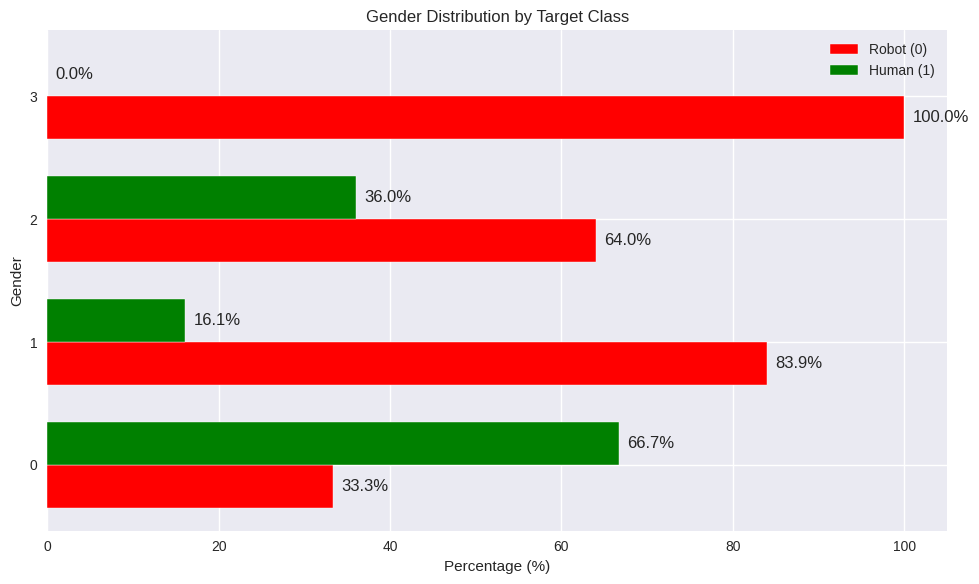

In [157]:
def plot_gender_vs_target(df):
    """
    Plots a bi-directional bar plot of gender distribution by target class.
    
    Parameters:
    df (DataFrame): DataFrame containing 'gender' and 'target' columns
                   (target: 0=robot, 1=human)
    """
    # Create a cross-tabulation of gender vs target
    cross_tab = pd.crosstab(df['gender'], df['target'])
    
    # Rename target values for better visualization
    cross_tab.columns = ['Robot (0)', 'Human (1)']
    
    # Calculate percentages for each gender
    cross_tab_perc = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Get the categories (genders) and bar positions
    categories = cross_tab.index
    y_pos = np.arange(len(categories))
    bar_width = 0.35
    
    # Plot left bars (Robots)
    left_bars = ax.barh(y_pos - bar_width/2, cross_tab_perc['Robot (0)'], 
                        bar_width, color='red', label='Robot (0)')
    
    # Plot right bars (Humans)
    right_bars = ax.barh(y_pos + bar_width/2, cross_tab_perc['Human (1)'], 
                         bar_width, color='green', label='Human (1)')
    
    # Add labels and title
    ax.set_xlabel('Percentage (%)')
    ax.set_ylabel('Gender')
    ax.set_title('Gender Distribution by Target Class')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(categories)
    ax.legend()
    
    # Add value labels on the bars
    for bar in left_bars:
        width = bar.get_width()
        ax.text(width + 1, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', ha='left', va='center')
    
    for bar in right_bars:
        width = bar.get_width()
        ax.text(width + 1, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()

plot_gender_vs_target(df)

## **3.2  Prétraitement des variables quanti**

In [158]:
def transform_quantitative_features(df, quantitative_vars, ratio_vars=None, epsilon=1e-5):
    """
    Applies Box-Cox transformation to strictly positive variables,
    Yeo-Johnson to those with zero or negative values,
    and log transform to ratio variables.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        quantitative_vars (list): List of numeric feature names.
        ratio_vars (list): List of ratio variable names (bounded between 0 and 1).
        epsilon (float): Small value to avoid division by zero in logit.

    Returns:
        transformed_df (pd.DataFrame): Transformed DataFrame.
        transformation_log (dict): Dict showing which transformation was applied to each column.
    """
    df_transformed = df.copy()
    transformation_log = {}

    for col in quantitative_vars:
        if (df_transformed[col] <= 0).any():
            pt = PowerTransformer(method='yeo-johnson', standardize=False)
            df_transformed[col] = pt.fit_transform(df_transformed[[col]])
            transformation_log[col] = 'yeo-johnson'
        else:
            transformed, _ = boxcox(df_transformed[col])
            df_transformed[col] = transformed
            transformation_log[col] = 'boxcox'

    if ratio_vars: # log(x / (1 - x))
        for col in ratio_vars:
            df_transformed[col + '_logit'] = np.log(
                (df_transformed[col] + epsilon) / (1 - df_transformed[col] + epsilon)
            )
            transformation_log[col] = 'logit'

    return df_transformed, transformation_log

In [159]:
quantitative_vars = [
    'posts_count', 'avg_likes', 'links_ratio', 'hashtags_ratio',
    'avg_keywords', 'avg_text_length', 'attachments_ratio', 'avg_comments',
    'reposts_ratio', 'ads_ratio', 'avg_views', 'posting_frequency_days',
    'phone_numbers_ratio', 'avg_text_uniqueness'
]

# Define which of them are ratios
ratio_vars = [
    'links_ratio', 'hashtags_ratio', 'attachments_ratio', 'reposts_ratio',
    'ads_ratio', 'phone_numbers_ratio', 'avg_text_uniqueness'
]

# Apply function
df, transformations_applied = transform_quantitative_features(df, quantitative_vars, ratio_vars)
transformations_applied

{'posts_count': 'boxcox',
 'avg_likes': 'yeo-johnson',
 'links_ratio': 'logit',
 'hashtags_ratio': 'logit',
 'avg_keywords': 'yeo-johnson',
 'avg_text_length': 'yeo-johnson',
 'attachments_ratio': 'logit',
 'avg_comments': 'yeo-johnson',
 'reposts_ratio': 'logit',
 'ads_ratio': 'logit',
 'avg_views': 'yeo-johnson',
 'posting_frequency_days': 'yeo-johnson',
 'phone_numbers_ratio': 'logit',
 'avg_text_uniqueness': 'logit'}

# **4. 🏗️ visualisation apres traitement**

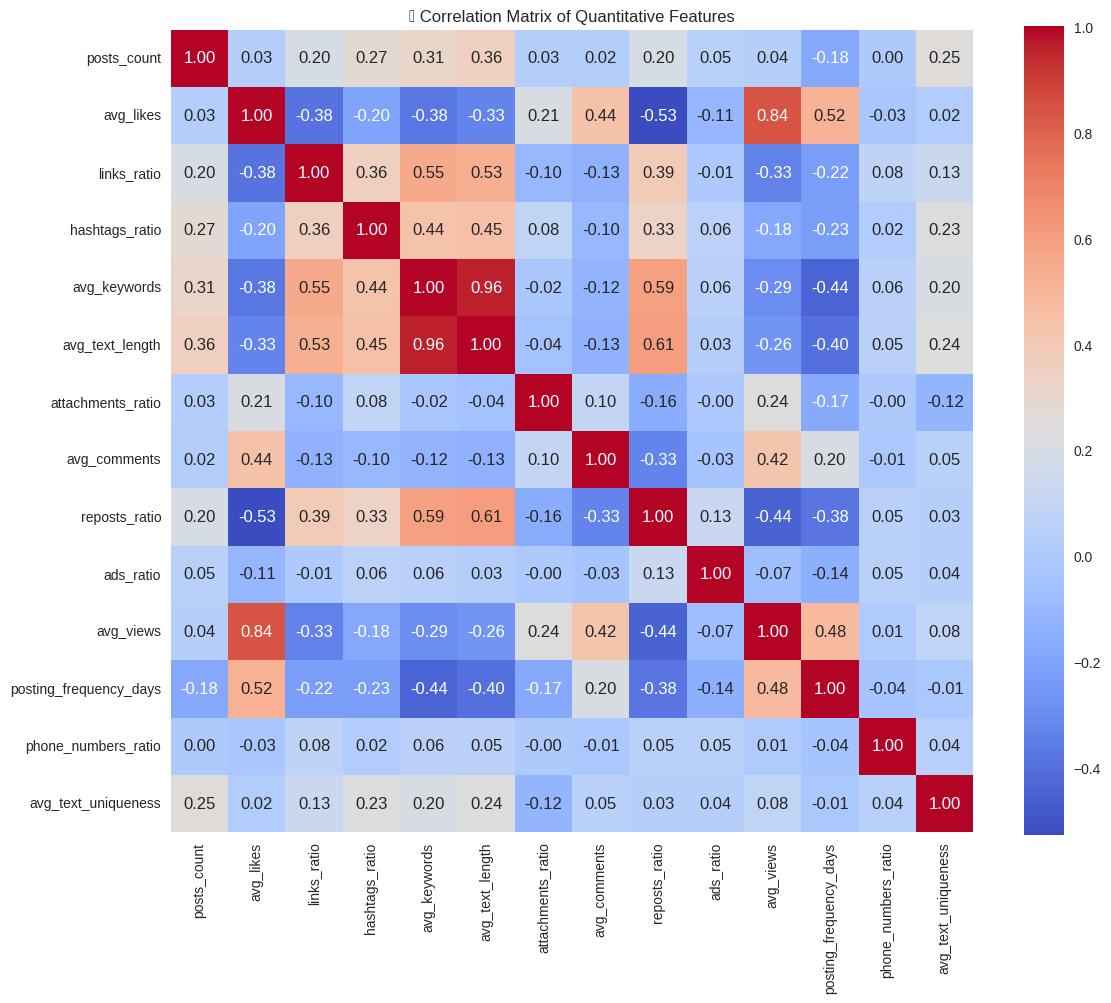

In [160]:
# Compute correlation matrix
corr_matrix = df[variables_type_numeric].corr()

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("📊 Correlation Matrix of Quantitative Features")
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')  
plt.show()

we drop avg_text lenght or avg keyword

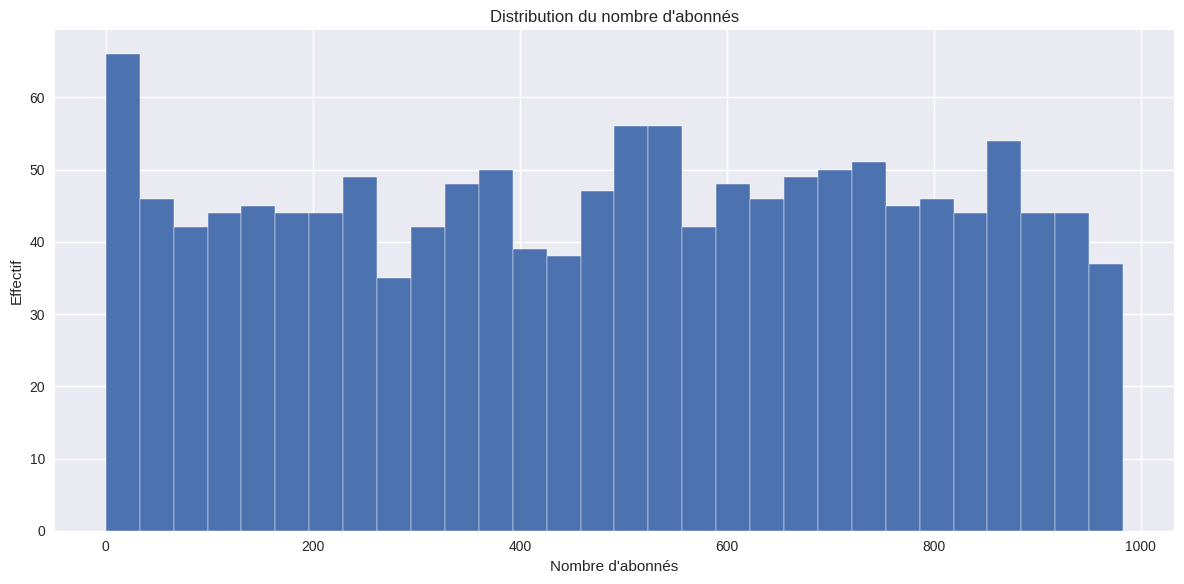

In [161]:
# Distribution du nombre d'abonnés
# utile pour détecter des extrêmes (influenceurs, comptes faibles).
plt.figure()
plt.hist(df['subscribers_count'], bins=30)
plt.title("Distribution du nombre d'abonnés")
plt.xlabel("Nombre d'abonnés")
plt.ylabel("Effectif")
plt.tight_layout()
plt.show()

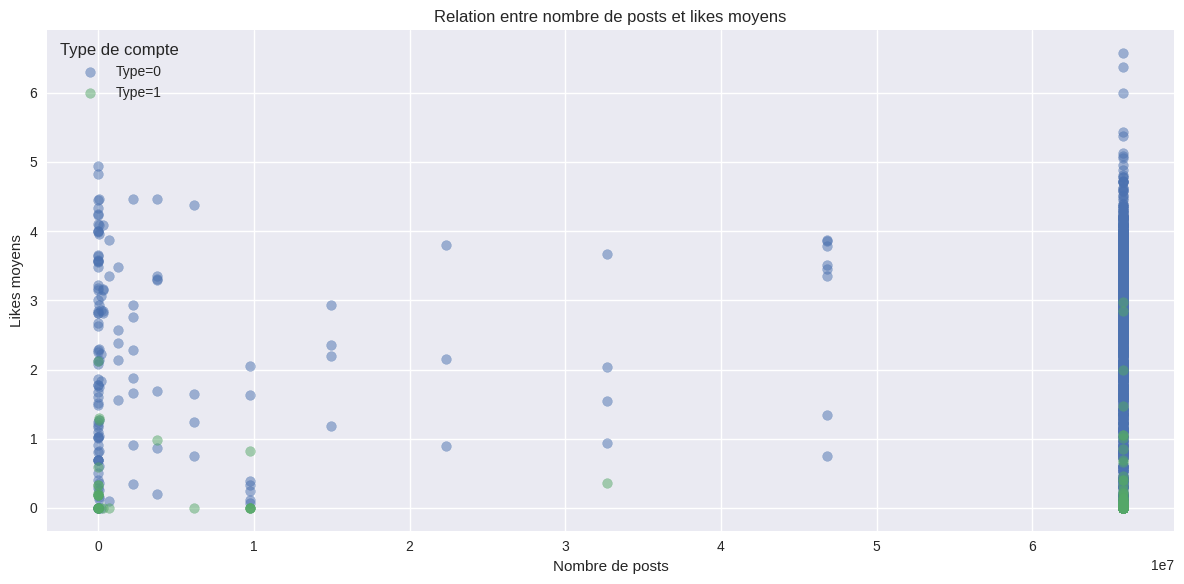

In [162]:
# Nuage de points pour évaluer le lien entre volume de publication et popularité,
# avec distinction bot/humain.
plt.figure()
for t in sorted(df['target'].unique()):
    subset = df[df['target'] == t]
    plt.scatter(subset['posts_count'], subset['avg_likes'], alpha=0.5, label=f"Type={t}")
plt.title("Relation entre nombre de posts et likes moyens")
plt.xlabel("Nombre de posts")
plt.ylabel("Likes moyens")
plt.legend(title="Type de compte")
plt.tight_layout()
plt.show()  ##### BAR PLOOOOOOTTT

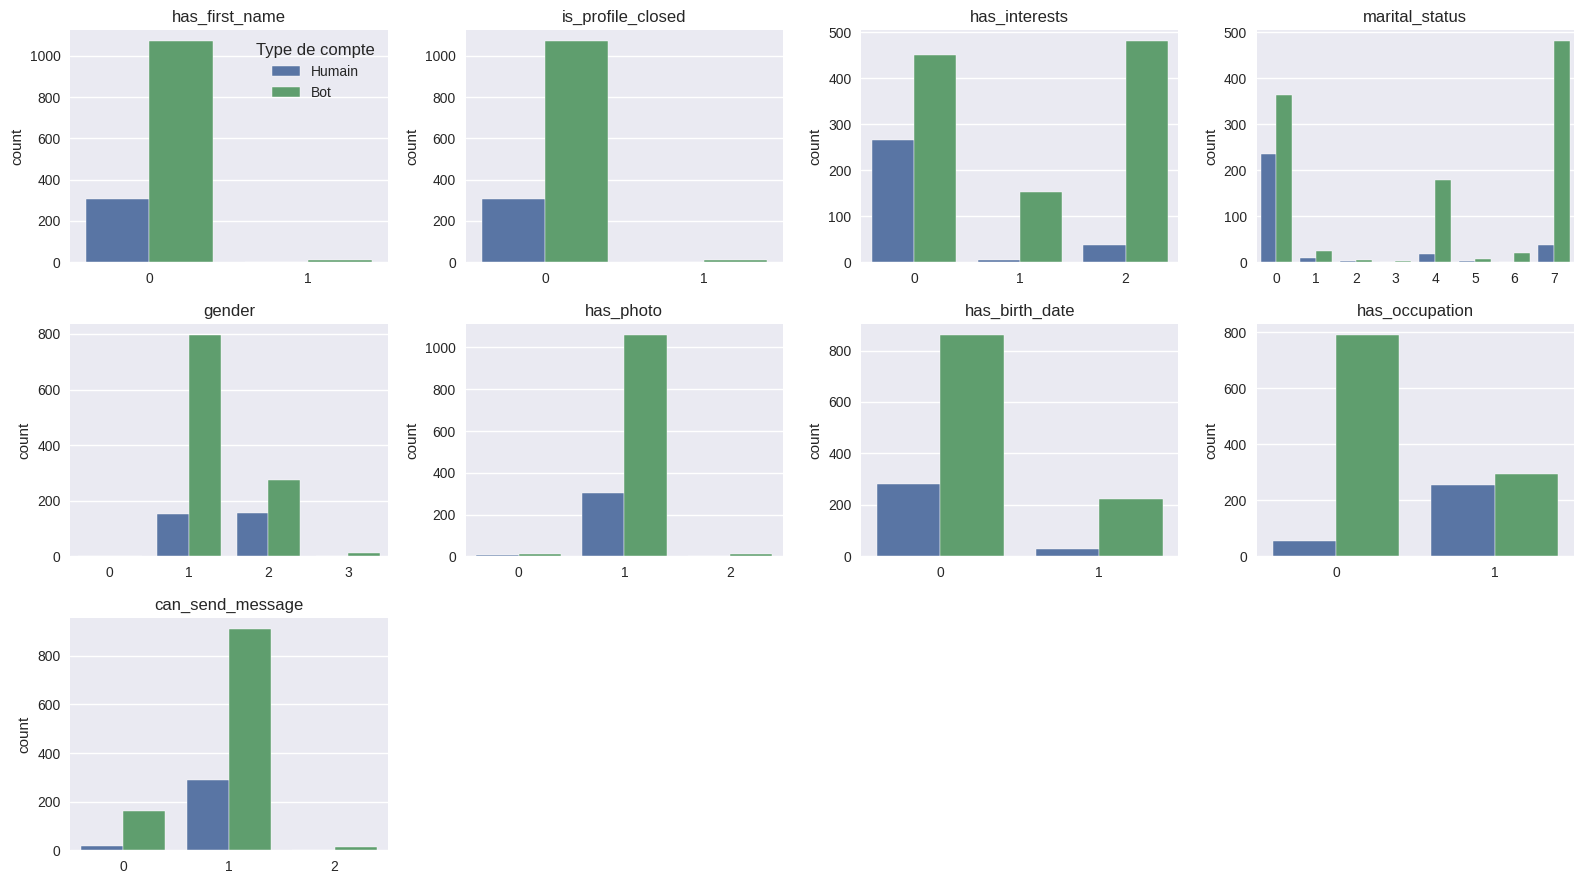

In [163]:
from math import ceil
data=df.copy()
vars_to_plot = [
    'has_first_name',      
    'is_profile_closed',      
    'has_interests',          
    'marital_status', 'gender', 
    'has_photo', 'has_birth_date', 'has_occupation',
    'can_send_message'        
]
data['Type_compte'] = data['target'].map({0: 'Bot', 1: 'Humain'})
# 4) Paramètres de la grille
n_cols = 4
n_vars = len(vars_to_plot)
n_rows = ceil(n_vars / n_cols)

# 6) Génération des countplots
# Puis ré-exécute le grid de countplots en utilisant hue='Type_compte'
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()
for idx, var in enumerate(vars_to_plot):
    ax = axes[idx]
    sns.countplot(data=data, x=var, hue='Type_compte', ax=ax)
    ax.set_title(var)
    ax.set_xlabel('')
    if idx == 0:
        ax.legend(title='Type de compte')
    else:
        ax.get_legend().remove()
for idx in range(n_vars, len(axes)):
    fig.delaxes(axes[idx])
plt.tight_layout()
plt.show()

# ![](http://)**5. 🧠 Feature Engineering**

In [164]:
df['engagement_score'] = (df['avg_likes'] + df['avg_comments']*2 + df['avg_views']/1000) / 4
df['content_richness'] = (df['links_ratio'] + df['hashtags_ratio'] + df['avg_text_length']/100) / 3
df['posts_per_day'] = df['posts_count'] / df['posting_frequency_days'].replace(0, 1)

columns_to_drop = ['avg_likes', 'avg_comments', 'avg_views','links_ratio','hashtags_ratio','avg_text_length','posts_count','posting_frequency_days',"avg_keywords","attachments_ratio_logit","avg_text_uniqueness_logit"]  # Your list of columns
df = df.drop(columns=columns_to_drop)
print("\nDataFrame after feature engineering:")
print(df.info())


DataFrame after feature engineering:
<class 'pandas.core.frame.DataFrame'>
Index: 1391 entries, 530 to 5873
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   has_birth_date             1391 non-null   int64  
 1   has_photo                  1391 non-null   int64  
 2   can_send_message           1391 non-null   int64  
 3   gender                     1391 non-null   int64  
 4   has_first_name             1391 non-null   int64  
 5   is_profile_closed          1391 non-null   int64  
 6   target                     1391 non-null   int64  
 7   has_interests              1391 non-null   int64  
 8   subscribers_count          1391 non-null   int64  
 9   marital_status             1391 non-null   int64  
 10  attachments_ratio          1391 non-null   float64
 11  reposts_ratio              1391 non-null   float64
 12  ads_ratio                  1391 non-null   float64
 13  phone_numbers

## 6 – Modélisation

### 6.1 Jeu d'entraînement / test

In [174]:
X = df.drop(columns=["target"])
y = df["target"].values

In [169]:
!pip install --upgrade threadpoolctl

In [175]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data (use y_resampled for stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, 
    y_resampled, 
    test_size=0.2, 
    stratify=y_resampled,  # Changed from y to y_resampled
    random_state=42
)

### 6.2 Sélection de variables + Logistic Regression

In [176]:
RANDOM_STATE = 42

✅ 7 variables communes : ['city_Unknown', 'content_richness', 'engagement_score', 'has_interests', 'has_occupation', 'posts_per_day', 'reposts_ratio']
Meilleurs hyperparamètres : {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       260
           1       0.94      0.94      0.94       260

    accuracy                           0.94       520
   macro avg       0.94      0.94      0.94       520
weighted avg       0.94      0.94      0.94       520



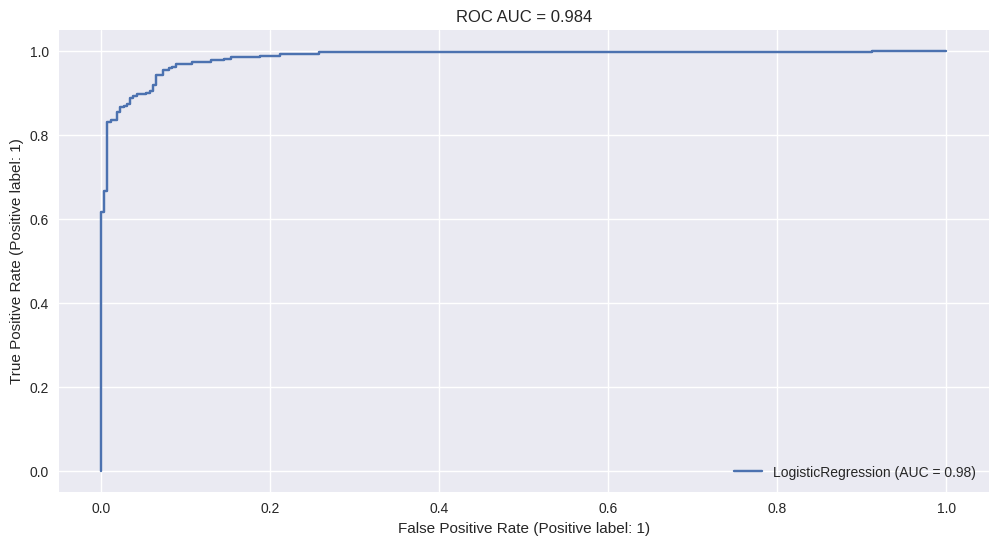

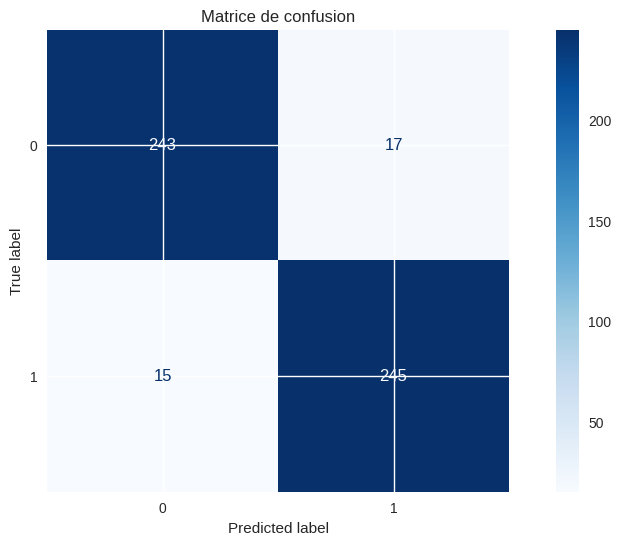

In [184]:
def feature_selection_lr(X, y, k=10, cv=5):
    feature_names = np.array(X.columns)
    X_mm = MinMaxScaler().fit_transform(X)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X_mm, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
    )

    # 1. Chi-2
    chi2_feats = feature_names[SelectKBest(chi2, k=k).fit(X_tr, y_tr).get_support()]
    # 2. ANOVA
    anova_feats = feature_names[SelectKBest(f_classif, k=k).fit(X_tr, y_tr).get_support()]
    # 3. RFECV
    rfecv = RFECV(
        LogisticRegression(max_iter=1000, solver="liblinear"),
        step=1, cv=cv, scoring="roc_auc"
    ).fit(X_tr, y_tr)
    rfecv_feats = feature_names[rfecv.support_]

    common_feats = sorted(set(chi2_feats) & set(anova_feats) & set(rfecv_feats))
    if not common_feats:
        raise ValueError("Pas de croisement entre les méthodes de sélection !")

    print(f"✅ {len(common_feats)} variables communes : {common_feats}")

    X_tr_sel = X_tr[:, [np.where(feature_names==f)[0][0] for f in common_feats]]
    X_te_sel = X_te[:, [np.where(feature_names==f)[0][0] for f in common_feats]]

    param_grid = {
        "C": [0.01, 0.1, 1, 10],
        "penalty": ["l1", "l2"],
        "solver": ["liblinear"]
    }

    gs = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid, cv=cv, scoring="roc_auc", n_jobs=-1
    ).fit(X_tr_sel, y_tr)

    best_lr = gs.best_estimator_
    y_pred = best_lr.predict(X_te_sel)
    y_prob = best_lr.predict_proba(X_te_sel)[:,1]

    print("Meilleurs hyperparamètres :", gs.best_params_)
    print(classification_report(y_te, y_pred))

    RocCurveDisplay.from_estimator(best_lr, X_te_sel, y_te)
    plt.title(f"ROC AUC = {roc_auc_score(y_te, y_prob):.3f}")
    plt.show()
    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=best_lr.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matrice de confusion")
    plt.show()

    return best_lr, common_feats

best_lr, selected_feats = feature_selection_lr(X_train, y_train)

Le modèle LogisticRegression avec les hyperparamètres ("C": 1, "penalty": 'l1', "solver": 'liblinear') 

La matrice de confusion révèle un faible nombre de faux positifs et faux négatifs, ce qui indique une bonne capacité à distinguer les bots des utilisateurs légitimes.
Avec un score AUC proche de 1, le modèle est très efficace pour classer les comptes automatisés. Les variables telles que "engagement_score", "reports_ratio", et "posts_per_key" ont probablement joué un rôle déterminant dans cette performance.

### 6.3 Arbre de Décision + RFE

In [186]:
from sklearn.tree import plot_tree

def decision_tree_rfe(X, y, n_feats=6, max_depth=4):
    feats = np.array(X.columns)
    rfe = RFE(
        DecisionTreeClassifier(max_depth=max_depth, random_state=RANDOM_STATE),
        n_features_to_select=n_feats
    ).fit(X, y)

    sel_feats = feats[rfe.support_]
    print(f"Features retenues : {list(sel_feats)}")

    X_tr, X_te, y_tr, y_te = train_test_split(
        X[sel_feats], y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
    )
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=RANDOM_STATE)
    dt.fit(X_tr, y_tr)

    # ← your confusion matrix
    ConfusionMatrixDisplay.from_estimator(dt, X_te, y_te, cmap="Blues")
    plt.title("Matrice de confusion – Decision Tree")
    plt.show()

    # ← add this for tree visualization
    plt.figure(figsize=(20, 10))
    plot_tree(
        dt,
        feature_names=sel_feats,
        class_names=[str(c) for c in dt.classes_],
        filled=True,
        rounded=True,
        fontsize=12
    )
    plt.title("Arbre de décision")
    plt.show()

    return dt, sel_feats

Features retenues : ['has_birth_date', 'attachments_ratio', 'avg_text_uniqueness', 'engagement_score', 'content_richness', 'posts_per_day']


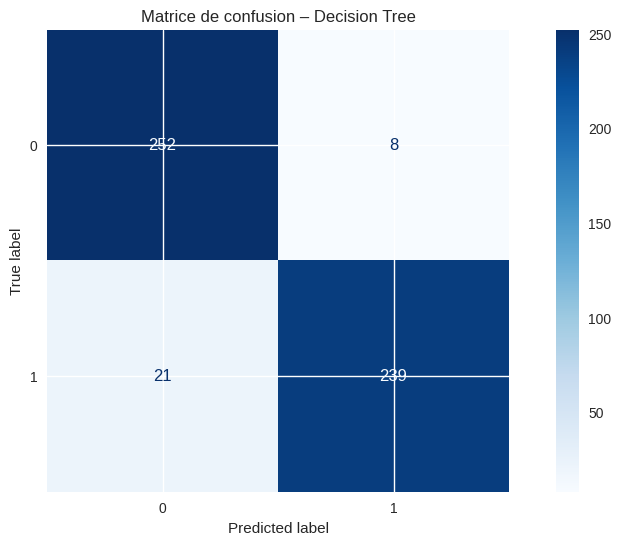

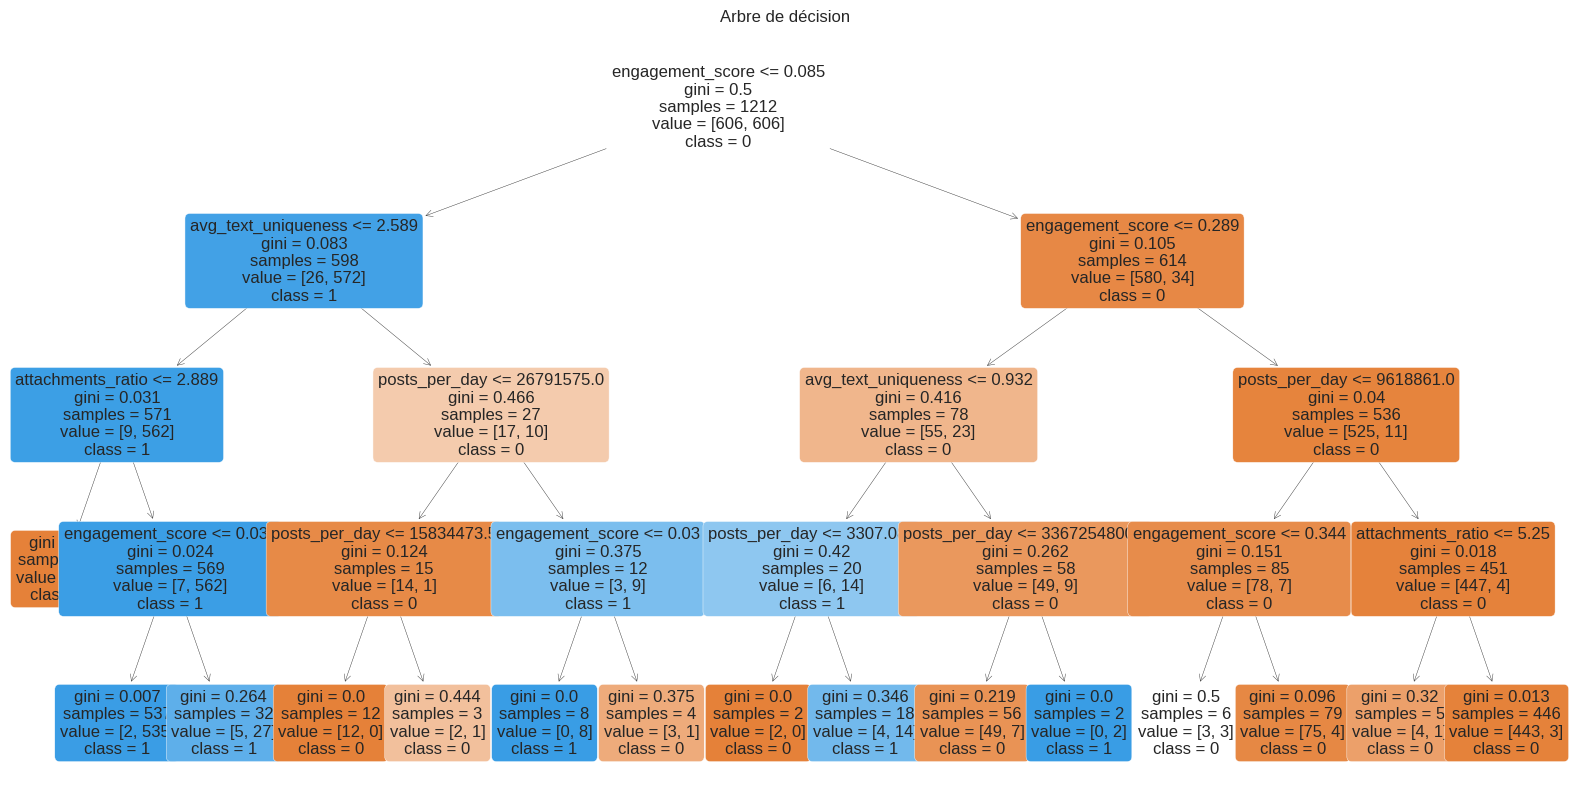

(DecisionTreeClassifier(max_depth=4, random_state=42),
 array(['has_birth_date', 'attachments_ratio', 'avg_text_uniqueness',
        'engagement_score', 'content_richness', 'posts_per_day'],
       dtype=object))

In [187]:
decision_tree_rfe(X_train, y_train)


  - Out of 550 test cases:  
    - 292 true humans correctly caught  
    - 229 true bots correctly caught  
    - 8 humans mis-flagged as bots  
    - 21 bots let through as humans  

 **Structure de l’arbre**  
  1. Premier split sur `engagement_score ≤ 0,085`  
  2. Ensuite `avg_text_uniqueness` et `posts_per_day`  
  3. Feuilles ultra-pures (Gini proche de 0), donc règles très claires et faciles à expliquer.  

- **Bilan**  
  - ✅ Modèle rapide, transparent et performant  
  - ⚠️ 21 bots passent à travers → on pourrait ajuster le seuil ou tester un modèle plus fin pour capturer ces cas limites  

### 6.4 Random Forest (Grid Search)

In [179]:
def rf_gridsearch(X, y, cv=5):
    pg = ParameterGrid({
        "n_estimators": [100, 200],
        "max_depth": [None, 10],
        "min_samples_split": [2, 5],
        "max_features": ["sqrt", "log2"]
    })

    best_auc = -np.inf
    best_params = None
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)

    for params in tqdm(pg, desc="Grid RF"):
        aucs = []
        for tr_idx, val_idx in skf.split(X, y):
            rf = RandomForestClassifier(**params, n_jobs=-1, random_state=RANDOM_STATE)
            rf.fit(X.iloc[tr_idx], y[tr_idx])
            proba = rf.predict_proba(X.iloc[val_idx])[:,1]
            aucs.append(roc_auc_score(y[val_idx], proba))
        mean_auc = np.mean(aucs)
        if mean_auc > best_auc:
            best_auc, best_params = mean_auc, params

    print(f"Best ROC-AUC : {best_auc:.3f} avec {best_params}")
    final_rf = RandomForestClassifier(**best_params, n_jobs=-1, random_state=RANDOM_STATE)
    final_rf.fit(X, y)
    return final_rf

rf_model = rf_gridsearch(X_train, y_train)

Grid RF:   0%|          | 0/16 [00:00<?, ?it/s]

Best ROC-AUC : 0.998 avec {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}


### 6.5 Bagging vs AdaBoost

Bootstrap AGGregation : tire N échantillons , entraîne N modèles **indépendants**, moyenne/vote.  Objectif = éduire **variance** (overfitting)  variance ↓ 
 
 Sequential ADAptive BOOSTing : entraîne modèles **série** ; chaque modèle corrige erreurs du précédent en ré-pondérant les exemples. Réduire **biais** en focalisant sur cas durs. → focus sur erreurs → biais ↓


In [180]:
def compare_ensembles(X, y, cv=5):
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
    )

    bag = BaggingClassifier(
        DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE),
        n_estimators=60, n_jobs=-1, random_state=RANDOM_STATE
    )
    boost = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE),
        n_estimators=100, random_state=RANDOM_STATE
    )

    for name, model in {"Bagging": bag, "AdaBoost": boost}.items():
        model.fit(X_tr, y_tr)
        prob = model.predict_proba(X_te)[:,1]
        print(f"{name} – ROC-AUC : {roc_auc_score(y_te, prob):.3f}")

compare_ensembles(X_train, y_train)

Bagging – ROC-AUC : 0.990
AdaBoost – ROC-AUC : 0.992


### 6.6 SVM (Grid Search manuel)

Grid SVM:   0%|          | 0/12 [00:00<?, ?it/s]

Best params : {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'} – CV ROC-AUC : 0.996


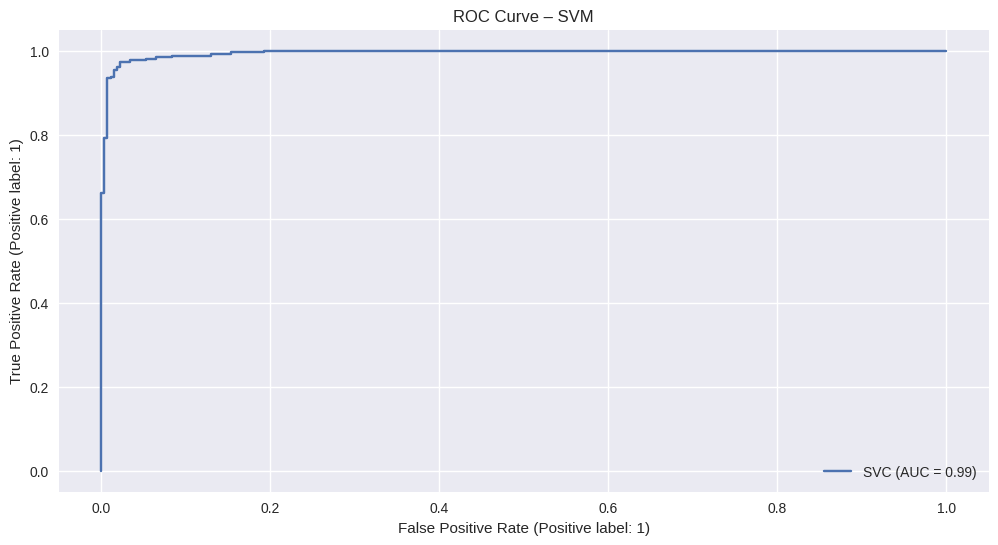

In [181]:
def svm_grid(X, y, cv=3):
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
    )
    scaler = StandardScaler().fit(X_tr)
    X_tr, X_te = scaler.transform(X_tr), scaler.transform(X_te)

    grid = ParameterGrid({
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", 0.1]
    })

    best_auc, best_params = -np.inf, None
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)

    for params in tqdm(grid, desc="Grid SVM"):
        aucs = []
        for tr_idx, val_idx in skf.split(X_tr, y_tr):
            svm = SVC(**params, probability=True, random_state=RANDOM_STATE)
            svm.fit(X_tr[tr_idx], y_tr[tr_idx])
            prob = svm.predict_proba(X_tr[val_idx])[:,1]
            aucs.append(roc_auc_score(y_tr[val_idx], prob))
        if np.mean(aucs) > best_auc:
            best_auc, best_params = np.mean(aucs), params

    print(f"Best params : {best_params} – CV ROC-AUC : {best_auc:.3f}")
    final_svm = SVC(**best_params, probability=True, random_state=RANDOM_STATE)
    final_svm.fit(X_tr, y_tr)

    RocCurveDisplay.from_estimator(final_svm, X_te, y_te)
    plt.title("ROC Curve – SVM"); plt.show()

    return final_svm

svm_model = svm_grid(X_train.values, y_train)

## 7 – Interprétabilité

### 7.1 SHAP sur Random Forest

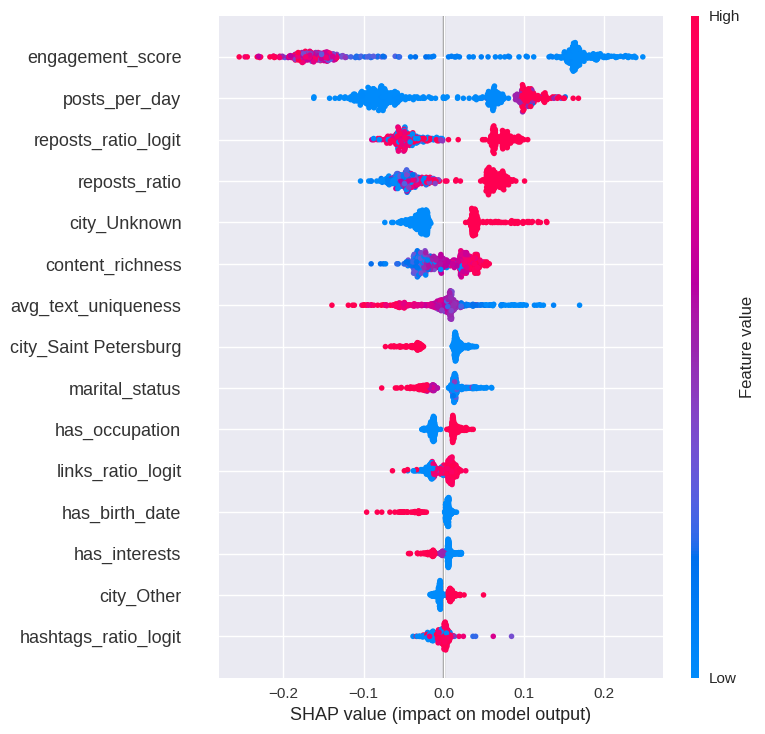

In [182]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, max_display=15)

**shap :** Quantifies l’impact de chaque feature sur **chaque prédiction**

- **engagement_score** : la variable la plus impactante. Les scores élevés (points rosés) poussent à fond vers la prédiction “bot” (SHAP > 0), tandis que les scores faibles (points bleus) protègent contre la classification en bot (SHAP < 0).  
- **posts_per_day** : 2ᵉ plus gros effet. Plus on poste, plus le modèle suspecte un bot.  
- **reposts_ratio_logit** & **reposts_ratio** : influence modérée. Un taux de reposts élevé oriente vers le bot, un taux bas protège.  
- **city_Unknown** : l’absence d’info ville tend à faire basculer vers “bot” (effet SHAP légèrement positif).  
- **content_richness** & **avg_text_uniqueness** : jouent un rôle mineur ; plus un contenu est riche ou unique, plus on reste dans la zone “non-bot”.  
- Les autres variables (marital_status, has_occupation, liens, hashtags…) ont un impact quasi nul (SHAP ≈ 0).


### 7.2 LIME sur un exemple

In [183]:
lime_exp = LimeTabularExplainer(
    training_data=np.array(X_train),
    mode="classification",
    feature_names=X_train.columns,
    class_names=["Bot", "Humain"],
    discretize_continuous=True,
    verbose=False
)
sample_idx = 0
exp = lime_exp.explain_instance(
    data_row=X_test.iloc[sample_idx],
    predict_fn=rf_model.predict_proba,
    num_features=10
)
exp.show_in_notebook(show_all=False)

**Lime :** Pour une prédiction donnée, crée un **petit modèle** autour du point, en perturbant les features. 

- Le modèle pense que c’est un **humain** (81 % de confiance).  
- **Ce qui fait pencher vers “humain”** :  
  - Le texte est **varié** (diversité des mots).  
  - L’utilisateur peut **envoyer des messages** normalement.  
- **Ce qui tire vers “bot”** :  
  - Trop de **hashtags** dans le contenu.  
  - Des **numéros de téléphone** apparaissent dans le texte. 